In [1]:
from google.colab import drive
drive.mount('/content/drive')
!pip install fastkml

Mounted at /content/drive
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.4/114.4 kB 4.4 MB/s eta 0:00:00


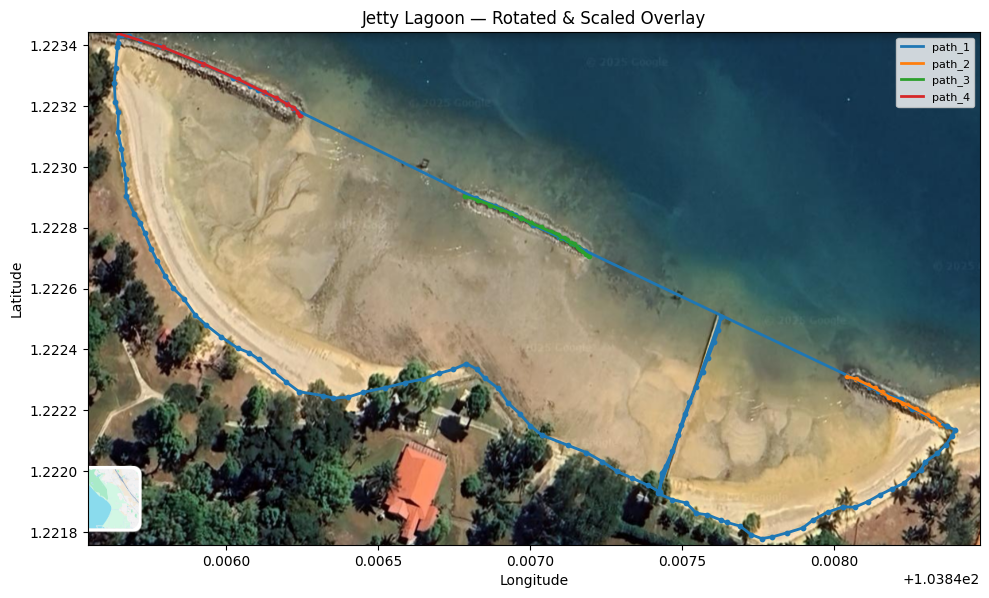

✅ Saved overlay to: /content/drive/Shareddrives/microscope videos/jetty_overlay_fixed.png


In [2]:
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import pandas as pd
# === INPUT FILES ===
IMG_PATH = "/content/drive/Shareddrives/75/outputs/jetty.png"
KML_PATH = "/content/drive/Shareddrives/75/outputs/jetty_coords.kml"
DEL_PATH = "/content/drive/Shareddrives/75/cleaned3.xlsx"#in X, Y
# === PARSE KML MANUALLY ===
tree = ET.parse(KML_PATH)
root = tree.getroot()

# find all coordinate elements regardless of namespace
coords_tags = root.findall(".//{*}coordinates")

paths = []
for tag in coords_tags:
    text = tag.text.strip()
    # Split coordinate triples: lon,lat,alt (alt optional)
    triplets = [p.split(",")[:2] for p in text.replace("\n", " ").split() if "," in p]
    lons, lats = zip(*[(float(x), float(y)) for x, y in triplets])
    paths.append({"lon": np.array(lons), "lat": np.array(lats)})

if not paths:
    raise RuntimeError("No <coordinates> tags found in your KML.")

# === DETERMINE EXTENT FROM ALL COORDINATES ===
all_lon = np.concatenate([p["lon"] for p in paths])
all_lat = np.concatenate([p["lat"] for p in paths])
xmin, xmax = all_lon.min(), all_lon.max()
ymin, ymax = all_lat.min(), all_lat.max()
extent = (xmin, xmax, ymin, ymax)

# === LOAD IMAGE ===
img = Image.open(IMG_PATH)

# === VISUAL ALIGNMENT CONTROLS ===
# You can tweak these small factors interactively until overlay matches visually
SCALE_X = 1.05   # shrink overlay horizontally (1.0 = no change)
SCALE_Y = 1.05   # shrink overlay vertically (1.0 = no change)
SHIFT_X = 0#0.00005  # positive shifts east (increase longitudes)
SHIFT_Y = 0#-0.00005 # positive shifts north (increase latitudes)
ROTATE_DEG = -1.5      # positive = counter-clockwise rotation in degrees

# === COMPUTE ADJUSTED EXTENT ===
lon_center = (xmin + xmax) / 2
lat_center = (ymin + ymax) / 2
width = (xmax - xmin) * SCALE_X
height = (ymax - ymin) * SCALE_Y

xmin_adj = lon_center - width / 2 + SHIFT_X
xmax_adj = lon_center + width / 2 + SHIFT_X
ymin_adj = lat_center - height / 2 + SHIFT_Y
ymax_adj = lat_center + height / 2 + SHIFT_Y
extent_adj = (xmin_adj, xmax_adj, ymin_adj, ymax_adj)

# === ROTATION FUNCTION ===
def rotate_points(lon, lat, lon0, lat0, angle_deg):
    """Rotate around (lon0, lat0) by angle_deg."""
    theta = np.deg2rad(angle_deg)
    cos_t, sin_t = np.cos(theta), np.sin(theta)
    x, y = lon - lon0, lat - lat0
    lon_r = lon0 + cos_t * x - sin_t * y
    lat_r = lat0 + sin_t * x + cos_t * y
    return lon_r, lat_r

# === ROTATE ALL PATHS ===
rotated_paths = []
for p in paths:
    lon_r, lat_r = rotate_points(p["lon"], p["lat"], lon_center, lat_center, ROTATE_DEG)
    rotated_paths.append({"lon": lon_r, "lat": lat_r})

# === PLOT ===
plt.figure(figsize=(10, 7))
plt.imshow(img, extent=extent_adj, origin="upper")

for i, p in enumerate(rotated_paths):
    plt.plot(p["lon"], p["lat"], linewidth=2, label=f"path_{i+1}")
    plt.scatter(p["lon"], p["lat"], s=10)

plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Jetty Lagoon — Rotated & Scaled Overlay")
plt.legend(fontsize=8)
plt.tight_layout()

outpath = "/content/drive/Shareddrives/microscope videos/jetty_overlay_fixed.png"
plt.savefig(outpath, dpi=300)
plt.show()
print("✅ Saved overlay to:", outpath)

In [3]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# === Load seagrass delimitation points ===
df_del = pd.read_excel(DEL_PATH)
df_del.columns = df_del.columns.str.strip()
df_del = df_del[["X", "Y"]].dropna()
df_del = df_del[df_del["Y"] > 1.218].reset_index(drop=True)

# === KMeans Clustering ===
k = 4  # Number of meadows to identify
kmeans = KMeans(n_clusters=k, random_state=42)
df_del["Cluster"] = kmeans.fit_predict(df_del[["X", "Y"]])
df_del.loc[(df_del['Cluster'] == 0) & (df_del['X'] > 103.847210), 'Cluster'] = 4
# === Rotate clustered points ===
rotated_meadows = []
for cluster_id in sorted(df_del["Cluster"].unique()):
    subset = df_del[df_del["Cluster"] == cluster_id]
    lon_r, lat_r = rotate_points(subset["X"].values, subset["Y"].values, lon_center, lat_center, ROTATE_DEG)
    rotated_meadows.append({
        "cluster": f"Meadow {cluster_id+1}",
        "lon": lon_r,
        "lat": lat_r
    })


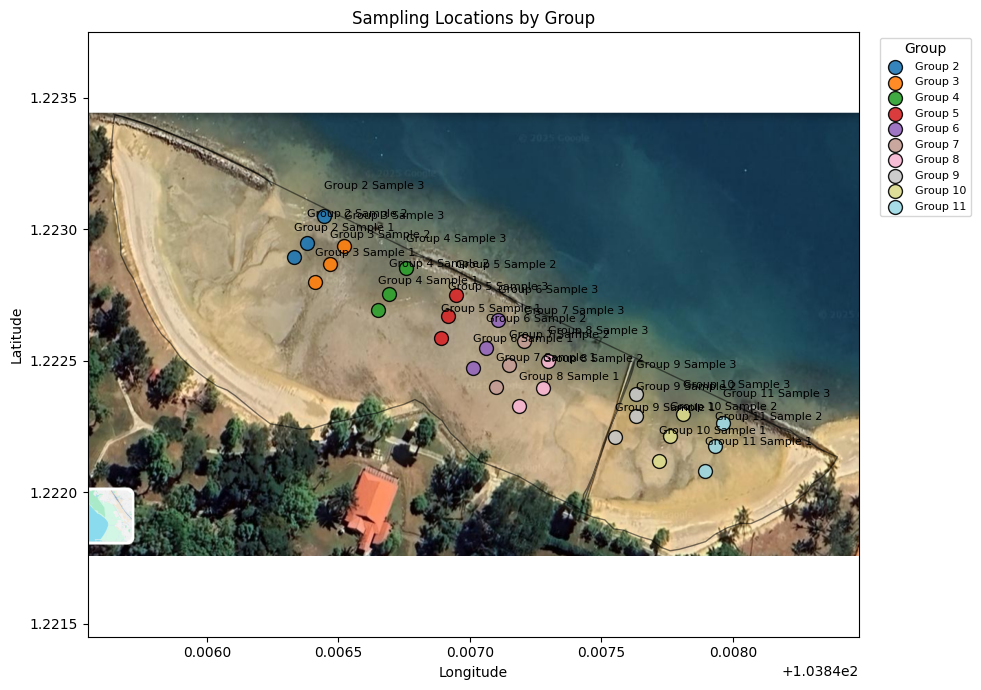

✅ Saved: /content/drive/Shareddrives/75/outputs/sampling_points_by_name.png


In [5]:
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import pandas as pd

# === FILE PATHS ===
IMG_PATH = "/content/drive/Shareddrives/75/outputs/jetty.png"
KML_PATH = "/content/drive/Shareddrives/75/outputs/jetty_coords.kml"
DATA_PATH = "/content/drive/Shareddrives/75/outputs/Sampling Data (1) (2).xlsx"

# === LOAD IMAGE ===
img = Image.open(IMG_PATH)

# === PARSE KML ===
tree = ET.parse(KML_PATH)
root = tree.getroot()
coords_tags = root.findall(".//{*}coordinates")
paths = []
for tag in coords_tags:
    triplets = [p.split(",")[:2] for p in tag.text.strip().replace("\n", " ").split() if "," in p]
    lons, lats = zip(*[(float(x), float(y)) for x, y in triplets])
    paths.append({"lon": np.array(lons), "lat": np.array(lats)})

# === EXTENT ===
all_lon = np.concatenate([p["lon"] for p in paths])
all_lat = np.concatenate([p["lat"] for p in paths])
xmin, xmax = all_lon.min(), all_lon.max()
ymin, ymax = all_lat.min(), all_lat.max()
lon_center = (xmin + xmax) / 2
lat_center = (ymin + ymax) / 2
SCALE_X, SCALE_Y = 1.05, 1.05
SHIFT_X, SHIFT_Y = 0, 0
ROTATE_DEG = -1.5

width = (xmax - xmin) * SCALE_X
height = (ymax - ymin) * SCALE_Y
extent_adj = (
    lon_center - width / 2 + SHIFT_X,
    lon_center + width / 2 + SHIFT_X,
    lat_center - height / 2 + SHIFT_Y,
    lat_center + height / 2 + SHIFT_Y
)

# === ROTATE ===
def rotate_points(lon, lat, lon0, lat0, angle_deg):
    theta = np.deg2rad(angle_deg)
    cos_t, sin_t = np.cos(theta), np.sin(theta)
    x, y = lon - lon0, lat - lat0
    lon_r = lon0 + cos_t * x - sin_t * y
    lat_r = lat0 + sin_t * x + cos_t * y
    return lon_r, lat_r

rotated_paths = []
for p in paths:
    lon_r, lat_r = rotate_points(p["lon"], p["lat"], lon_center, lat_center, ROTATE_DEG)
    rotated_paths.append({"lon": lon_r, "lat": lat_r})

# === LOAD DATA ===
df = pd.read_excel(DATA_PATH)
df.columns = df.columns.str.strip()
df = df.dropna(subset=["X", "Y", "Name"])

# Extract "Group" from "Name"
df["Group"] = df["Name"].str.extract(r"(Group \d+)", expand=False)

# Rotate coordinates
df["lon_rot"], df["lat_rot"] = rotate_points(df["X"], df["Y"], lon_center, lat_center, ROTATE_DEG)

# === PLOT ===
plt.figure(figsize=(10, 7))
plt.imshow(img, extent=extent_adj, origin="upper")

# Draw KML boundaries
for p in rotated_paths:
    plt.plot(p["lon"], p["lat"], color="black", linewidth=1, alpha=0.5)

# Color by group
groups = df["Group"].dropna().unique()
colors = plt.cm.tab20(np.linspace(0, 1, len(groups)))
color_map = dict(zip(groups, colors))
for group in groups:
    subset = df[df["Group"] == group]
    plt.scatter(
        subset["lon_rot"], subset["lat_rot"],
        label=group, s=100,
        color=color_map[group],
        edgecolor="black", alpha=0.9
    )
    for _, row in subset.iterrows():
        plt.text(row["lon_rot"], row["lat_rot"] + 0.0001, row["Name"], fontsize=8)

plt.title("Sampling Locations by Group")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.axis("equal")
plt.legend(title="Group", fontsize=8, bbox_to_anchor=(1.02, 1), loc="upper left")
plt.tight_layout()

outpath = "/content/drive/Shareddrives/75/outputs/sampling_points_by_name.png"
plt.savefig(outpath, dpi=300)
plt.show()
print("✅ Saved:", outpath)



🔍 Preview of df_sites used for plotting:
   Site_ID     lon_rot   lat_rot  Shoot Biomass (g)  Coverage (%)  \
0     10_1  103.847720  1.222120           1.155000     20.800000   
1     10_2  103.847762  1.222215           1.065000     24.400000   
2     10_3  103.847809  1.222297           0.668571     23.200000   
3     11_1  103.847896  1.222081           0.441972      8.666667   
4     11_2  103.847932  1.222175           6.735654     24.600000   
5     11_3  103.847962  1.222262           2.231429     25.000000   
6      1_1         NaN       NaN                NaN           NaN   
7      1_2         NaN       NaN                NaN           NaN   
8      1_3         NaN       NaN                NaN           NaN   
9      2_1  103.846332  1.222895           0.998000     14.400000   
10     2_2  103.846379  1.222947           1.074000     18.000000   
11     2_3  103.846446  1.223052           1.576000     20.400000   
12     3_1  103.846412  1.222798           0.604000     22.00

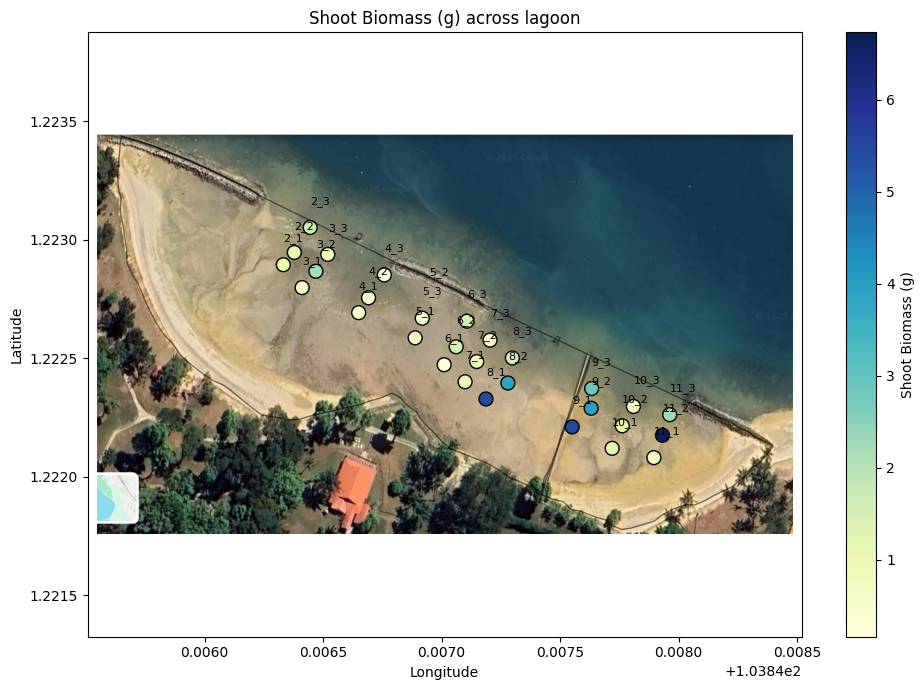

Coverage (%)


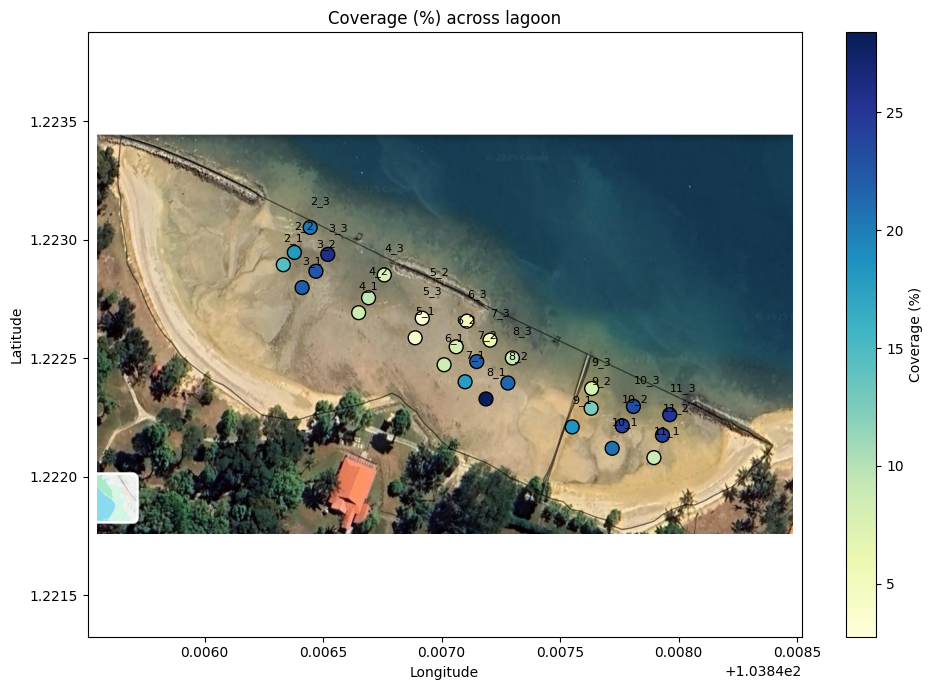

Shoot Density (m^-2)


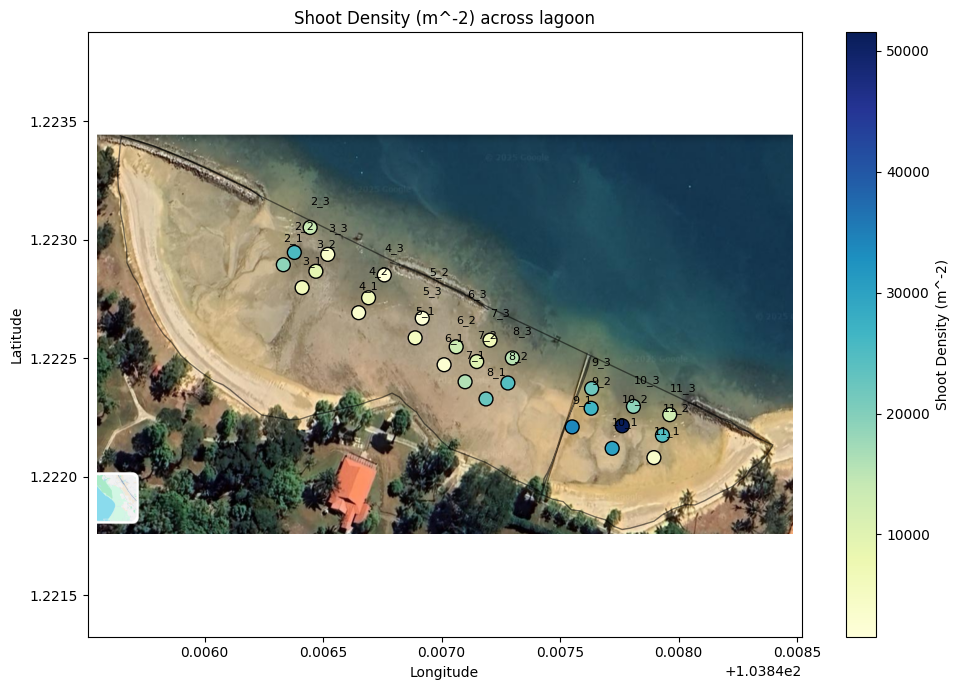

In [6]:
# === Median at each coordinate visualization ===
from io import StringIO

df_quadrats = pd.read_excel('/content/drive/Shareddrives/75/outputs/Master Sheet.xlsx')#pd.read_csv(StringIO(data_q))
#

df_quadrats.columns = df_quadrats.columns.str.strip()
df_quadrats[["Group No.", "Sample Site"]] = df_quadrats[["Group No.", "Sample Site"]].ffill()
# Identify the metric columns
metric_cols = [
    "Shoot Count", "Shoot Biomass (g)", "Root Biomass (g)",
    "Coverage (%)", "Shoot Density (m^-2)", "Total Biomass (g)"
]

# Force numeric conversion and coerce errors to NaN
for col in metric_cols:
    df_quadrats[col] = pd.to_numeric(df_quadrats[col], errors="coerce")
df_quadrats.head()
# Use zero-padded integers or just integers as strings (recommended)
df_quadrats["Site_ID"] = (
    df_quadrats["Group No."].astype(int).astype(str) + "_" +
    df_quadrats["Sample Site"].astype(int).astype(str)
)


# From the previous section — get coordinates for each Group+Site
df_coords = df.copy()
df_coords["Group No."] = df_coords["Group"].str.extract(r"(\d+)").astype(int)
df_coords["Sample Site"] = df_coords["Name"].str.extract(r"Sample (\d+)").astype(int)
df_coords["Site_ID"] = (
    df_coords["Group No."].astype(int).astype(str) + "_" +
    df_coords["Sample Site"].astype(int).astype(str)
)

df_coords = df_coords[["Site_ID", "lon_rot", "lat_rot"]].drop_duplicates()

# Merge coordinates into quadrat data
df_merged = pd.merge(df_quadrats, df_coords, on="Site_ID", how="left")

# === AGGREGATE BY COORDINATE ===
agg_cols = [
    "Shoot Count", "Shoot Biomass (g)", "Root Biomass (g)",
    "Coverage (%)", "Shoot Density (m^-2)", "Total Biomass (g)"
]

df_sites = df_merged.groupby("Site_ID").agg({
    **{col: "mean" for col in agg_cols},
    "lon_rot": "first", "lat_rot": "first"
}).reset_index()

# === PLOTTING FUNCTION ===
def plot_variable_overlay(col, cmap="YlGnBu", size=100):
    plt.figure(figsize=(10, 7))
    plt.imshow(img, extent=extent_adj, origin="upper")

    # Boundary overlay
    for p in rotated_paths:
        plt.plot(p["lon"], p["lat"], color="black", linewidth=1, alpha=0.5)

    # Sampling points
    sc = plt.scatter(
        df_sites["lon_rot"], df_sites["lat_rot"],
        c=df_sites[col], cmap=cmap,
        s=size, edgecolors="black"
    )
    for _, row in df_sites.iterrows():
        plt.text(row["lon_rot"], row["lat_rot"] + 0.0001, row["Site_ID"], fontsize=8)

    plt.colorbar(sc, label=col)
    plt.title(f"{col} across lagoon")
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.axis("equal")
    plt.tight_layout()
    plt.show()



# === EXAMPLE: PLOT SELECTED METRICS ===
metrics_to_plot = ["Shoot Biomass (g)", "Coverage (%)", "Shoot Density (m^-2)"]
print("\n🔍 Preview of df_sites used for plotting:")
print(df_sites[["Site_ID", "lon_rot", "lat_rot"] + metrics_to_plot])

print("\n🧼 Null values per column:")
print(df_sites[["lon_rot", "lat_rot"] + metrics_to_plot].isna().sum())

print("\n✅ Number of fully valid points to plot:")
valid_rows = df_sites.dropna(subset=["lon_rot", "lat_rot"] + metrics_to_plot)
print(f"{len(valid_rows)} valid out of {len(df_sites)} total sites")


df_sites.head()
for m in metrics_to_plot:
    if m in df_sites.columns:
      print(m)
      plot_variable_overlay(m)


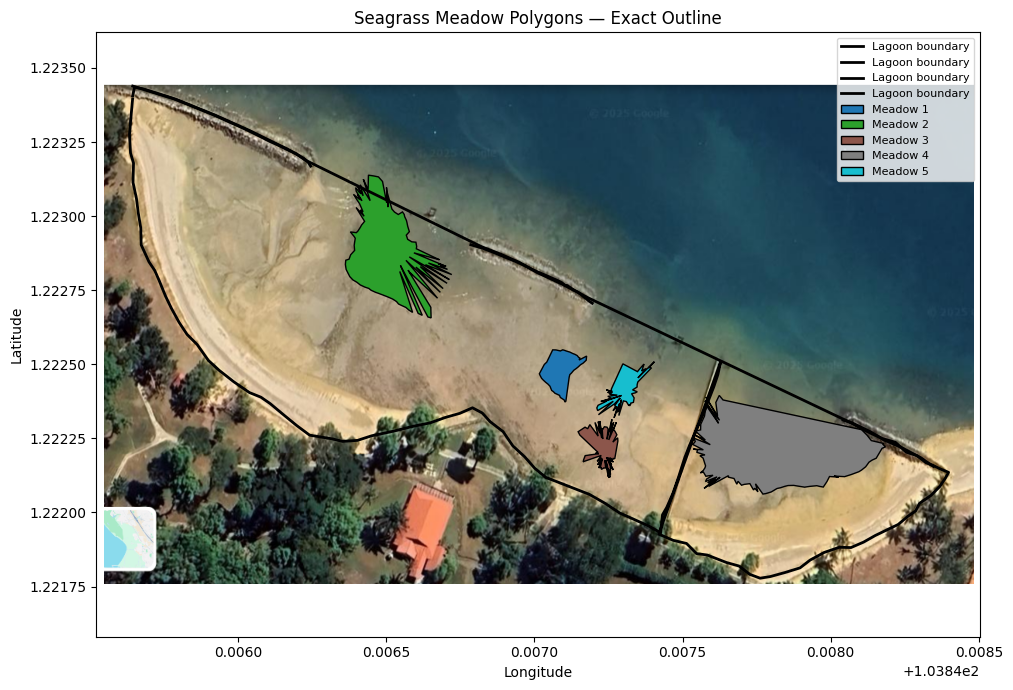

✅ Saved to: /content/drive/Shareddrives/75/outputs/seagrass_meadow_exact_polygons.png


In [7]:
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
import numpy as np

fig, ax = plt.subplots(figsize=(10, 7))
ax.imshow(img, extent=extent_adj, origin="upper")

# Plot lagoon boundary
for p in rotated_paths:
    ax.plot(p["lon"], p["lat"], color="black", linewidth=2, label="Lagoon boundary")

colors = plt.cm.tab10(np.linspace(0, 1, len(rotated_meadows)))

for i, meadow in enumerate(rotated_meadows):
    lon = np.array(meadow["lon"])
    lat = np.array(meadow["lat"])

    if len(lon) < 3:
        continue  # skip polygons that can't form a shape

    # Center of the meadow for sorting
    lon_center = lon.mean()
    lat_center = lat.mean()

    # Compute angle from center to each point (for sorting)
    angles = np.arctan2(lat - lat_center, lon - lon_center)
    sorted_indices = np.argsort(angles)

    # Get sorted polygon points
    polygon_pts = np.column_stack([lon[sorted_indices], lat[sorted_indices]])

    # Create and add polygon
    poly = Polygon(polygon_pts, closed=True, facecolor=colors[i], alpha=1,
                   edgecolor='black', label=meadow["cluster"])
    ax.add_patch(poly)

    # Optionally scatter the points (for debugging/visualizing input)
    #ax.plot(lon, lat, 'o', color=colors[i], markersize=3)

# Final plot formatting
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.set_title("Seagrass Meadow Polygons — Exact Outline")
ax.axis("equal")
ax.legend(fontsize=8)
plt.tight_layout()

# Save figure
outpath = "/content/drive/Shareddrives/75/outputs/seagrass_meadow_exact_polygons.png"
plt.savefig(outpath, dpi=300)
plt.show()

print(f"✅ Saved to: {outpath}")


In [ ]:
from matplotlib.patches import Polygon

# === Filter df_sites to valid interpolation points ===
df_plot_data = df_sites.dropna(subset=["lon_rot", "lat_rot", "Shoot Density (m^-2)"])
points = df_plot_data[["lon_rot", "lat_rot"]].values
values = df_plot_data["Shoot Density (m^-2)"].values

# === Create interpolation grid ===
grid_lon = np.linspace(xmin_adj, xmax_adj, 300)
grid_lat = np.linspace(ymin_adj, ymax_adj, 300)
grid_x, grid_y = np.meshgrid(grid_lon, grid_lat)
grid_z = griddata(points, values, (grid_x, grid_y), method='cubic')
grid_z = np.where(grid_z < 0, 0, grid_z)

# === Define contour levels ===
z_min = 0
z_max = np.nanmax(grid_z)
levels = np.linspace(z_min, z_max, 100)

# === Begin figure ===
fig, ax = plt.subplots(figsize=(10, 7))

# === Show lagoon background ===
ax.imshow(img, extent=extent_adj, origin="upper")

# === Plot interpolated heatmap ===
contour = ax.contourf(
    grid_x, grid_y, grid_z,
    levels=levels, cmap="plasma", alpha=1, vmin=0,linewidths=0
)

# === Overlay sampling points ===
ax.scatter(points[:, 0], points[:, 1], c="black", s=30, edgecolors="white", label="Sampling Sites")

# === Overlay meadow polygons ===
colors = plt.cm.tab10(np.linspace(0, 1, len(rotated_meadows)))
added_meadow_label = False  # Flag to control legend entry

for i, meadow in enumerate(rotated_meadows):
    lon = np.array(meadow["lon"])
    lat = np.array(meadow["lat"])

    if len(lon) < 3:
        continue  # skip invalid

    lon_center = lon.mean()
    lat_center = lat.mean()
    angles = np.arctan2(lat - lat_center, lon - lon_center)
    sorted_idx = np.argsort(angles)
    polygon_pts = np.column_stack([lon[sorted_idx], lat[sorted_idx]])

    # Add label only to the first polygon
    poly = Polygon(
        polygon_pts,
        closed=True,
        facecolor='none',
        edgecolor='green',
        linewidth=0.5,
        alpha=1,
        label="Seagrass Meadow" if not added_meadow_label else None
    )
    ax.add_patch(poly)
    added_meadow_label = True

# === Final plot formatting ===
ax.set_title("Shoot Density Heatmap with Seagrass Meadow Overlays")
#ax.set_xlabel("Longitude")
#ax.set_ylabel("Latitude")
cbar = plt.colorbar(contour, ax=ax, label="Shoot Density (m$^{-2}$)", shrink=0.5)
ax.set_xticks([])
ax.set_yticks([])
#ax.axis("equal")
ax.legend(fontsize=8, loc="lower left")
# === Add 30-meter scale bar ===
scale_length_m = 30  # meters
scale_length_deg = scale_length_m / 111300  # degrees at your latitude

# Bottom-left position for the bar
x_start = xmin_adj + 0.0025
y_start = ymin_adj + 0.0015
x_end = x_start + scale_length_deg

# Draw horizontal scale line
ax.plot([x_start, x_end], [y_start, y_start], color='white', linewidth=2, zorder=10)

# Add vertical whiskers
ax.plot([x_start, x_start], [y_start - 0.00001, y_start + 0.00001], color='white', linewidth=1.5, zorder=10)
ax.plot([x_end, x_end], [y_start - 0.00001, y_start + 0.00001], color='white', linewidth=1.5, zorder=10)

# Add text label centered above the scale bar
ax.text((x_start + x_end) / 2, y_start + 0.00008, "30 m",
        color='white', ha='center', va='bottom', fontsize=8,
        bbox=dict(facecolor='black', edgecolor='none', pad=1.5, alpha=0.6), zorder=11)

plt.tight_layout()

# === Save ===
outpath = "/content/drive/Shareddrives/75/outputs/shoot_density_heatmap_with_meadows.png"
plt.savefig(outpath, dpi=300)
plt.show()
print(f"✅ Saved: {outpath}")


In [ ]:
from matplotlib.patches import Polygon
from scipy.interpolate import griddata
import matplotlib.pyplot as plt
import numpy as np




'''# === Metrics to plot ===
metrics = [
    "Shoot Density (m^-2)",
    "Shoot Biomass (g)",
    "Coverage (%)",
    "Total Biomass (g)",
    "Root Biomass (g)",
    "Shoot Count",
    "Shoot:Root Ratio"
    # Add more if needed
]'''
# === Metrics to plot ===
metrics = [
    "Shoot:Root Ratio"
    # Add more if needed
]
for metric in metrics:
    if metric not in df_sites.columns:
        print(f"⚠️ Skipping missing metric: {metric}")
        continue

    # === Filter valid points ===
    df_plot_data = df_sites.dropna(subset=["lon_rot", "lat_rot", metric])
    points = df_plot_data[["lon_rot", "lat_rot"]].values
    values = df_plot_data[metric].values

    if len(points) < 3:
        print(f"⚠️ Not enough points to interpolate: {metric}")
        continue

    # === Interpolation grid ===
    grid_x, grid_y = np.meshgrid(
        np.linspace(xmin_adj, xmax_adj, 300),
        np.linspace(ymin_adj, ymax_adj, 300)
    )
    grid_z = griddata(points, values, (grid_x, grid_y), method='cubic')
    grid_z = np.where(grid_z < 0, 0, grid_z)

    z_min = 0
    z_max = np.nanmax(grid_z)
    levels = np.linspace(z_min, z_max, 100)

    # === Begin figure ===
    fig, ax = plt.subplots(figsize=(10, 7))
    ax.imshow(img, extent=extent_adj, origin="upper")

    # === Heatmap ===
    contour = ax.contourf(
        grid_x, grid_y, grid_z,
        levels=levels, cmap="plasma", alpha=1, vmin=0
    )

    # === Sampling points ===
    ax.scatter(points[:, 0], points[:, 1], c="black", s=30, edgecolors="white", label="Sampling Sites")

    # === Seagrass meadow overlay ===
    added_meadow_label = False
    for meadow in rotated_meadows:
        lon = np.array(meadow["lon"])
        lat = np.array(meadow["lat"])
        if len(lon) < 3:
            continue

        lon_center = lon.mean()
        lat_center = lat.mean()
        angles = np.arctan2(lat - lat_center, lon - lon_center)
        sorted_idx = np.argsort(angles)
        polygon_pts = np.column_stack([lon[sorted_idx], lat[sorted_idx]])

        poly = Polygon(
            polygon_pts, closed=True, facecolor='none', edgecolor='green',
            linewidth=0.5,
            label="Seagrass Meadow" if not added_meadow_label else None
        )
        ax.add_patch(poly)
        added_meadow_label = True

    # === Scale bar ===
    scale_length_m = 30
    scale_length_deg = scale_length_m / 111300
    x_start = xmin_adj + 0.0025
    y_start = ymin_adj + 0.0015
    x_end = x_start + scale_length_deg

    ax.plot([x_start, x_end], [y_start, y_start], color='white', linewidth=2, zorder=10)
    ax.plot([x_start, x_start], [y_start - 0.00001, y_start + 0.00001], color='white', linewidth=1.5, zorder=10)
    ax.plot([x_end, x_end], [y_start - 0.00001, y_start + 0.00001], color='white', linewidth=1.5, zorder=10)
    ax.text((x_start + x_end) / 2, y_start + 0.00008, "30 m",
            color='white', ha='center', va='bottom', fontsize=8,
            bbox=dict(facecolor='black', edgecolor='none', pad=1.5, alpha=0.6), zorder=11)

    # === Final formatting ===
    ax.set_title(metric, fontsize=13)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.legend(fontsize=8, loc="lower left")

    # === Colorbar ===
    cbar = plt.colorbar(contour, ax=ax, label=metric, shrink=0.5)

    # === Save ===
    safe_metric = metric.replace(" ", "_").replace("(", "").replace(")", "").replace("/", "_")
    outpath = f"/content/drive/Shareddrives/75/outputs/heatmap_{safe_metric}.png"
    plt.tight_layout()
    plt.savefig(outpath, dpi=300)
    plt.close(fig)
    print(f"✅ Saved: {outpath}")


In [ ]:
from matplotlib.patches import Polygon
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import griddata

# Replace infinite values with NaN and optionally fill or drop them
df_sites["Shoot:Root Ratio"] = df_sites["Shoot Biomass (g)"] / df_sites["Root Biomass (g)"]
df_sites["Shoot:Root Ratio"].replace([np.inf, -np.inf], np.nan, inplace=True)

# === Variables to plot ===
metrics = [
    "Shoot Density (m^-2)",
    "Shoot Biomass (g)",
    "Coverage (%)",
    "Total Biomass (g)",
    "Root Biomass (g)",
    "Shoot Count",
    "Shoot:Root Ratio"
    # Add more if needed
]

# === Setup subplot grid ===
n_rows = 3
n_cols = 3
#fig, axes = plt.subplots(n_rows, n_cols, figsize=(24, 18))
fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 12),
                         gridspec_kw={'wspace': 0.05, 'hspace': 0.02})  # ↓ reduced hspace
axes = axes.flatten()



# === Loop through variables ===
for i, metric in enumerate(metrics_to_plot):
    ax = axes[i]

    # Filter valid data
    df_plot_data = df_sites.dropna(subset=["lon_rot", "lat_rot", metric])
    points = df_plot_data[["lon_rot", "lat_rot"]].values
    values = df_plot_data[metric].values

    # Grid setup
    grid_lon = np.linspace(xmin_adj, xmax_adj, 300)
    grid_lat = np.linspace(ymin_adj, ymax_adj, 300)
    grid_x, grid_y = np.meshgrid(grid_lon, grid_lat)
    grid_z = griddata(points, values, (grid_x, grid_y), method='cubic')
    grid_z = np.where(grid_z < 0, 0, grid_z)

    z_min = 0
    z_max = np.nanmax(grid_z)
    levels = np.linspace(z_min, z_max, 100)

    # Plot base image
    ax.imshow(img, extent=extent_adj, origin="upper")

    # Heatmap
    contour = ax.contourf(
        grid_x, grid_y, grid_z,
        levels=levels, cmap="plasma", alpha=1, vmin=0
    )

    # Sample points
    ax.scatter(points[:, 0], points[:, 1], c="black", s=30, edgecolors="white",label='Sampling Points')

    # Meadow overlay (green outline only once in legend)
    added_meadow_label = False
    for meadow in rotated_meadows:
        lon = np.array(meadow["lon"])
        lat = np.array(meadow["lat"])
        if len(lon) < 3:
            continue
        lon_center, lat_center = lon.mean(), lat.mean()
        angles = np.arctan2(lat - lat_center, lon - lon_center)
        sorted_idx = np.argsort(angles)
        polygon_pts = np.column_stack([lon[sorted_idx], lat[sorted_idx]])
        poly = Polygon(
            polygon_pts, closed=True,
            facecolor='none', edgecolor='green',
            linewidth=0.5, alpha=1,
            label="Seagrass Meadow" if not added_meadow_label else None
        )
        ax.add_patch(poly)
        added_meadow_label = True

    # Title, axis, scale bar
    ax.set_title(metric, fontsize=16)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.legend(fontsize=12, loc="lower left")
    # Scale bar (only on top-left plot or any specific one you prefer)
    if True:
        scale_length_m = 30
        scale_length_deg = scale_length_m / 111300
        x_start = xmin_adj + 0.0025
        y_start = ymin_adj + 0.0015
        x_end = x_start + scale_length_deg
        ax.plot([x_start, x_end], [y_start, y_start], color='white', linewidth=2)
        ax.plot([x_start, x_start], [y_start - 0.00001, y_start + 0.00001], color='white', linewidth=1.5)
        ax.plot([x_end, x_end], [y_start - 0.00001, y_start + 0.00001], color='white', linewidth=1.5)
        ax.text((x_start + x_end) / 2, y_start + 0.00008, "30 m",
                color='white', ha='center', va='bottom', fontsize=12,
                bbox=dict(facecolor='black', edgecolor='none', pad=1.5, alpha=0.6))

    # Colorbar per plot
    cbar = plt.colorbar(contour, ax=ax, shrink=0.5, pad=0.01)
    cbar.set_label(metric, fontsize=12)

# Hide unused axes if any
for j in range(len(metrics_to_plot), len(axes)):
    fig.delaxes(axes[j])

#plt.tight_layout(pad=0.2)
save_path = "/content/drive/Shareddrives/75/outputs/seagrass_all_metrics_composite.png"
plt.savefig(save_path, dpi=600)
plt.show()

print(f"✅ Composite figure saved to: {save_path}")


In [ ]:
############# t test #######################

plt.figure(figsize=(8, 6))
plt.imshow(img, extent=extent_adj, origin="upper")
plt.plot(rotated_paths[0]['lon'], rotated_paths[0]['lat'], 'r-', linewidth=2)
plt.title("First Polygon from KML Overlay (rotated_paths[0])")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.axis("equal")
plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
from scipy.stats import ttest_ind

# === Data Arrays ===
group_between = [
    33858.85886, 31511.11111, 46981.68498, 15824.24242, 22266.66667,
    8279.365079, 17333.33333, 1644.444444, 52385.18519, 30344.82759,
    28977.77778, 31466.66667, 59600, 43466.66667, 25822.22222, 12400
]

group_behind = [
    2711.111111, 3723.809524, 5872.941176, 24948.57143, 26851.85185,
    14088.88889, 24044.44444, 33333.33333, 12622.22222
]

# === Convert to NumPy arrays ===
a = np.array(group_between)
b = np.array(group_behind)

# === Descriptive Statistics ===
mean_a = np.mean(a)
std_a = np.std(a, ddof=1)

mean_b = np.mean(b)
std_b = np.std(b, ddof=1)

print("Group A (Between Breakwater):")
print(f"  Mean = {mean_a:.2f}")
print(f"  Std Dev = {std_a:.2f}")

print("\nGroup B (Behind Breakwater):")
print(f"  Mean = {mean_b:.2f}")
print(f"  Std Dev = {std_b:.2f}")

# === Unpaired t-test (equal variance assumed) ===
t_stat, p_two_tailed = ttest_ind(a, b, equal_var=True)

# One-tailed p-values
p_right = p_two_tailed / 2 if t_stat > 0 else 1 - (p_two_tailed / 2)
p_left = p_two_tailed / 2 if t_stat < 0 else 1 - (p_two_tailed / 2)

print("\nT-Test Results (Equal Variance Assumed):")
print(f"  t-statistic = {t_stat:.4f}")
print(f"  Two-tailed p-value = {p_two_tailed:.4f}")
print(f"  Right-tailed p-value (A > B) = {p_right:.4f}")
print(f"  Left-tailed p-value (A < B) = {p_left:.4f}")
